# 杭州萧山区项目`WRF-CMAQ`模拟分析
## 模拟结果分析：*`Integrated Source Apportionment Method`*

---
*@author: Evan*\
*@date: 2023-08-30*

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../../src/')
import ModelEvaLib as me
from namelist import *

## 读取数据

In [2]:
isam = xr.open_dataset(isamfile)
isam

<xarray.Dataset>
Dimensions:    (time: 744, level: 26, y: 138, x: 135)
Coordinates:
  * time       (time) datetime64[ns] 2023-05-01 ... 2023-05-31T23:00:00
  * level      (level) float64 1e+03 998.0 995.8 993.4 ... 703.9 659.0 616.2
    latitude   (y, x) float32 ...
    longitude  (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables: (12/13)
    O3_Nor     (time, level, y, x) float32 ...
    O3_NW      (time, level, y, x) float32 ...
    O3_FY      (time, level, y, x) float32 ...
    O3_SE      (time, level, y, x) float32 ...
    O3_XS      (time, level, y, x) float32 ...
    O3_XSI     (time, level, y, x) float32 ...
    ...         ...
    O3_XST     (time, level, y, x) float32 ...
    O3_XSR     (time, level, y, x) float32 ...
    O3_XSS     (time, level, y, x) float32 ...
    O3_OTH     (time, level, y, x) float32 ...
    O3_ICO     (time, level, y, x) float32 ...
    O3_BCO     (time, level, y, x) float32 ...
Attributes:
    case:        Xiaoshan_202305
    grid:        CN3XS_135X138
    createtime:  2023-08-28

In [3]:
# get the variables with filter
name_list = [name for name in list(isam.variables) if 'O3' in name]
tag_list  = [name.split('_')[1] for name in name_list]

print(name_list)
print(tag_list)

data_list = []
for i in range(len(name_list)): 
    data_list.append(isam[name_list[i]])

['O3_Nor', 'O3_NW', 'O3_FY', 'O3_SE', 'O3_XS', 'O3_XSI', 'O3_XSP', 'O3_XST', 'O3_XSR', 'O3_XSS', 'O3_OTH', 'O3_ICO', 'O3_BCO']
['Nor', 'NW', 'FY', 'SE', 'XS', 'XSI', 'XSP', 'XST', 'XSR', 'XSS', 'OTH', 'ICO', 'BCO']


In [4]:
L1_dict = {}
L2_dict = {}

for tag, var in zip(tag_list, data_list):
    # 在 L1 字典中存储 L1 变量
    L1_dict[f"{tag}"] = var[:,0,:,:]
    # L1_dict[f"{tag}_L1"] = np.mean(var[:,:4,:,:], axis=1)
    
    # 在 L2 字典中存储 L2 变量
    L2_dict[f"{tag}"] = np.mean(var[:,4:19,:,:], axis=1)

# 将 L1 和 L2 字典合并到一个字典中
# combined_dict = {**L1_dict, **L2_dict}

# 解包字典，将变量重新赋值给原始变量名称
# globals().update(combined_dict)

In [5]:
import geopandas as gpd
import shapely.geometry as sgeom
from shapely.prepared import prep

def polygon_to_mask(polygon, x, y):
    '''
    Generate a mask array of points falling into the polygon
    '''
    x = np.atleast_1d(x)
    y = np.atleast_1d(y)
    mask = np.zeros(x.shape, dtype=bool)

    # if each point falls into a polygon, without boundaries
    prepared = prep(polygon)
    for index in np.ndindex(x.shape):
        point = sgeom.Point(x[index], y[index])
        if prepared.contains(point):
            mask[index] = True

    return mask

def mask_to_mean(var,mask_da):
    '''
    Calculate the mean of a variable after applying a mask.

    Parameters:
        var (xarray.DataArray): Input variable.
        mask_da (xarray.DataArray): Mask with dimensions ('y', 'x').

    Returns:
        xarray.DataArray: Mean of the masked variable along dimensions ('y', 'x').

    '''
    
    masked = var.where(mask_da)
    mean = masked.mean(dim=['y','x'],skipna=True)
    
    return mean

In [6]:
lon = isam.longitude
lat = isam.latitude
shp = gpd.read_file(shpxs)

mask = polygon_to_mask(shp.geometry[0],lon,lat)
mask_da = xr.DataArray(mask,dims=('y','x'))

# var_L1_dict = {key + '_mean': value for key, value in L1_dict.items()}

mean_dict = {}
for key, variable in L1_dict.items():
    mean_dict[key] = mask_to_mean(variable, mask_da)
    

In [7]:
df_L1 = pd.DataFrame.from_dict(mean_dict, orient='columns')
df_L1.index = pd.date_range(timestart,timeend,freq='h')

df_mda8 = df_L1.rolling(8).mean().resample('D').max()

df_mda8.keys()

Index(['Nor', 'NW', 'FY', 'SE', 'XS', 'XSI', 'XSP', 'XST', 'XSR', 'XSS', 'OTH',
       'ICO', 'BCO'],
      dtype='object')

## 画图

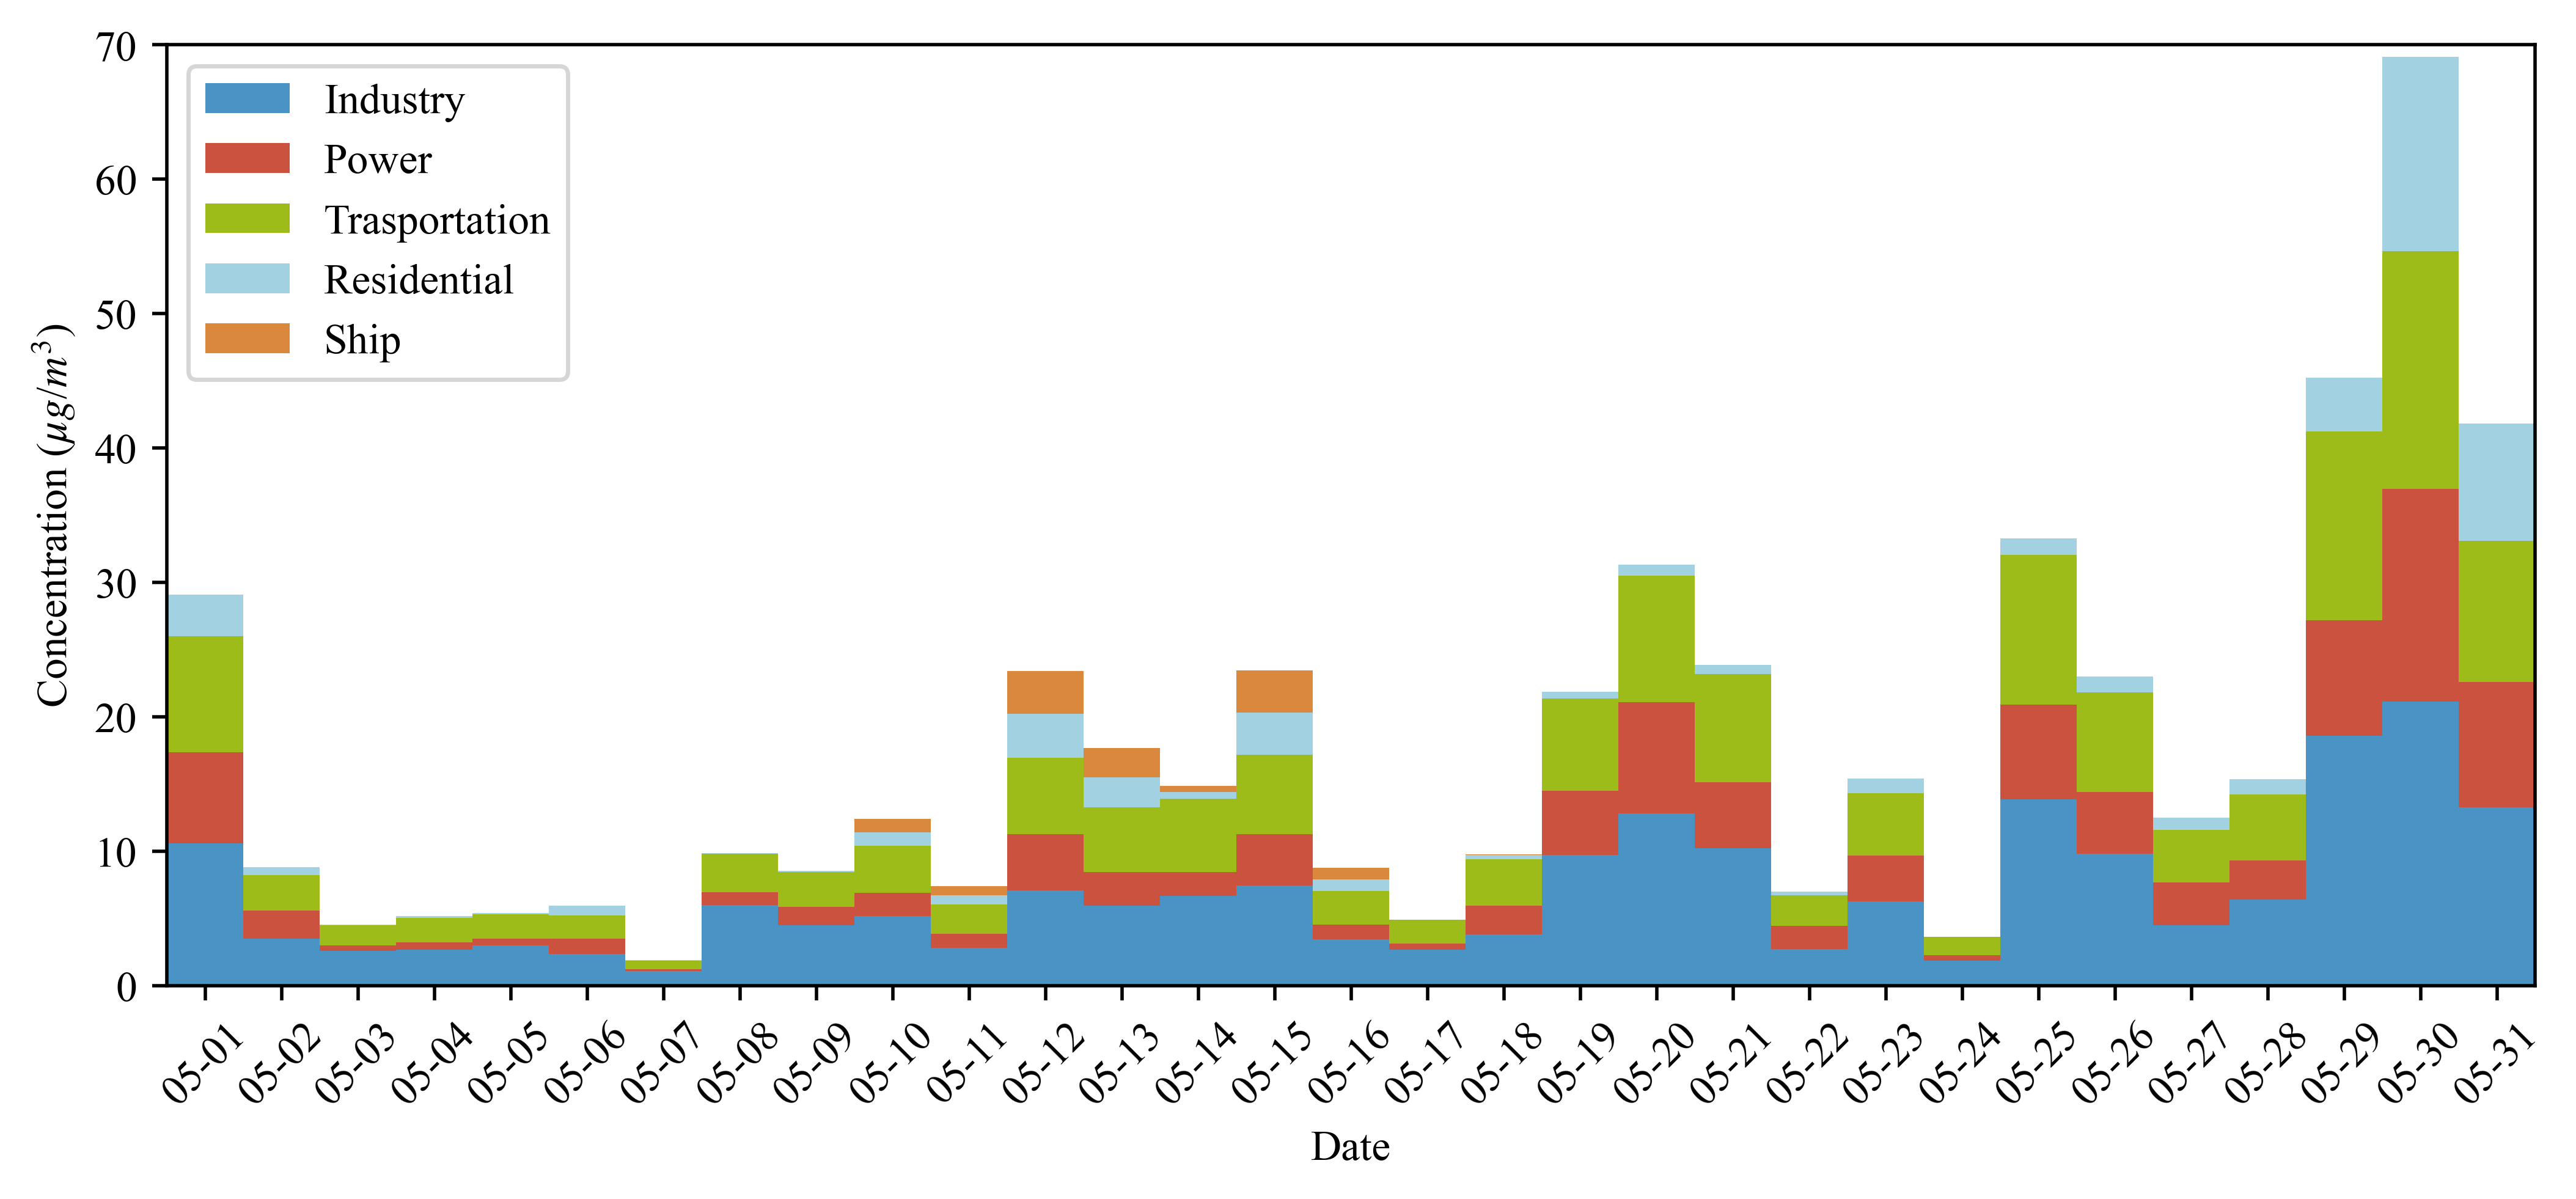

In [10]:
ts = np.arange(0, 31)

data = {
    'XSI' : {'label': 'Industry', 'color': '#4994c4'},
    'XSP': {'label': 'Power', 'color': '#cb523e'},
    'XST' : {'label': 'Trasportation', 'color': '#9ebc19'},
    'XSR' : {'label': 'Residential', 'color': '#a2d2e2'},
    'XSS' : {'label': 'Ship', 'color': '#d9883d'},
}

fig, ax = plt.subplots(figsize=(10, 4), dpi=500)

bottom = np.zeros(len(ts))

for key, value in data.items():
    b = ax.bar(ts, df_mda8[key], bottom=bottom, color=value['color'], width=1)
    bottom += df_mda8[key]
    data[key]['bar'] = b

ax.legend([data[key]['bar'][0] for key in data.keys()],
          [data[key]['label'] for key in data.keys()],
          loc=2) #bbox_to_anchor=(1.18, 0.99))
ax.set_xlabel('Date')
ax.set_ylabel('Concentration ($\mu$$g$/$m^3$)')
ax.set_xticks(ts)
ax.set_xticklabels(pd.date_range(timestart,timeend,freq='D').strftime('%m-%d'), rotation=45)
ax.set_yticks(np.arange(0, 71, 10))
ax.set_ylim(0, 70)
ax.set_xlim(-0.5, 30.5)

plt.show()

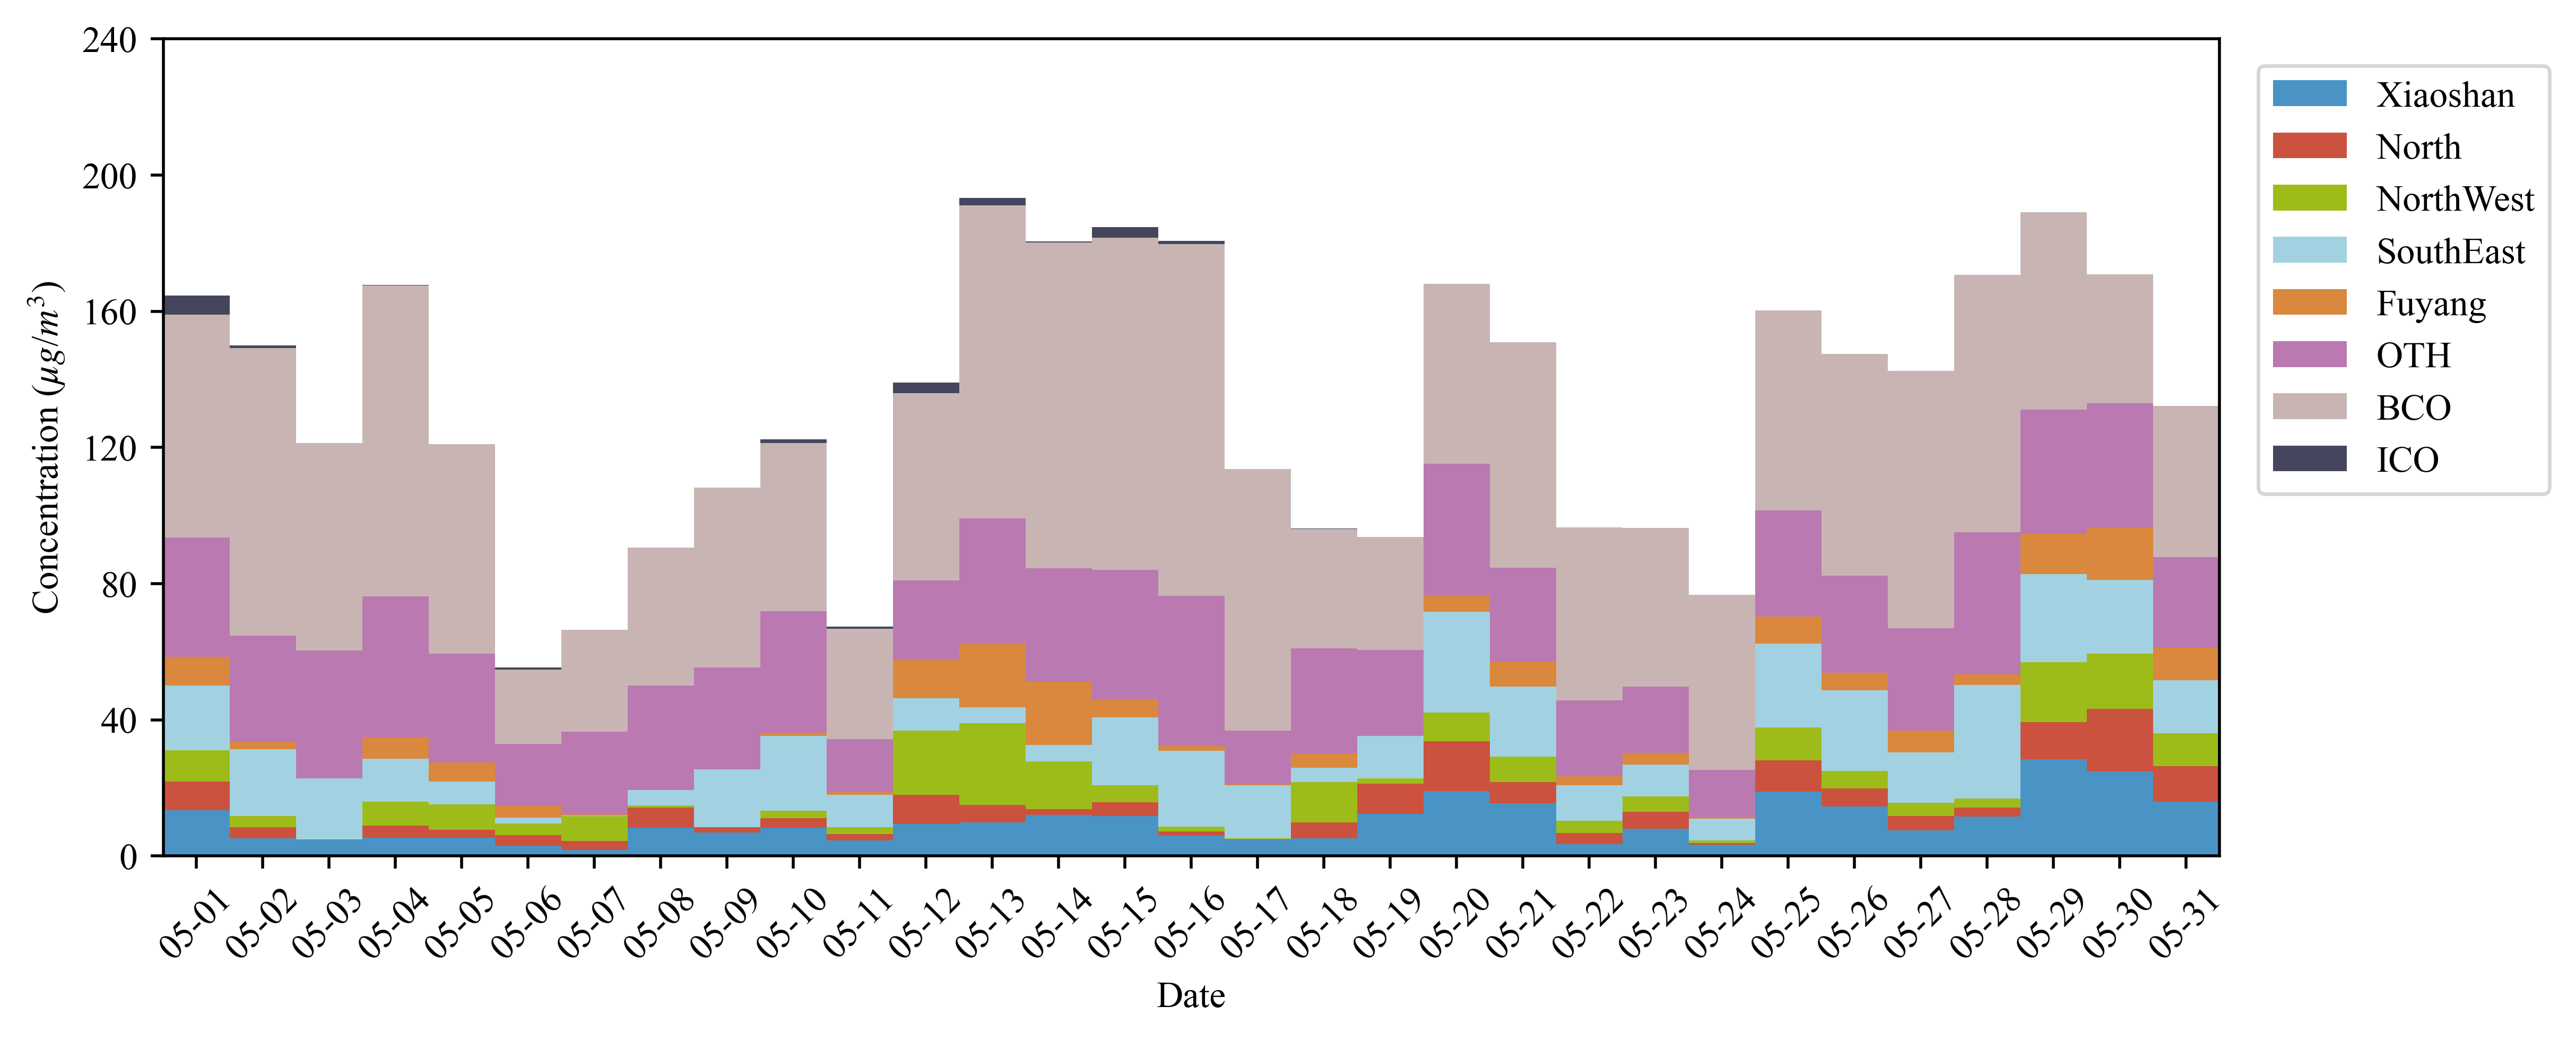

In [11]:
ts = np.arange(0, 31)

data = {
    'XS' : {'label': 'Xiaoshan', 'color': '#4994c4'},
    'Nor': {'label': 'North', 'color': '#cb523e'},
    'NW' : {'label': 'NorthWest', 'color': '#9ebc19'},
    'SE' : {'label': 'SouthEast', 'color': '#a2d2e2'},
    'FY' : {'label': 'Fuyang', 'color': '#d9883d'},
    'OTH': {'label': 'OTH', 'color': '#ba79b1'},
    'BCO': {'label': 'BCO', 'color': '#c8b5b3'},
    'ICO': {'label': 'ICO', 'color': '#45465e'}
}

fig, ax = plt.subplots(figsize=(10, 4), dpi=500)

bottom = np.zeros(len(ts))

for key, value in data.items():
    b = ax.bar(ts, df_mda8[key], bottom=bottom, color=value['color'], width=1)
    bottom += df_mda8[key]
    data[key]['bar'] = b

ax.legend([data[key]['bar'][0] for key in data.keys()],
          [data[key]['label'] for key in data.keys()],
          bbox_to_anchor=(1.01, 0.99))
ax.set_xlabel('Date')
ax.set_ylabel('Concentration ($\mu$$g$/$m^3$)')
ax.set_xticks(ts)
ax.set_xticklabels(pd.date_range(timestart,timeend,freq='D').strftime('%m-%d'), rotation=45)
ax.set_yticks(np.arange(0, 241, 40))
ax.set_ylim(0, 240)
ax.set_xlim(-0.5, 30.5)

plt.show()